In [2]:
pip install qiskit-aqua

     |████████████████████████████████| 2.1 MB 24 kB/s s eta 0:00:01
     |████████████████████████████████| 4.5 MB 70 kB/s s eta 0:00:01
  Created wheel for dlx: filename=dlx-1.0.4-py3-none-any.whl size=5718 sha256=b2d8e12cfa8d58d8aeaf64dc16d8f0060e96680de5542a5e72f5d725019e08d5
  Stored in directory: /home/jovyan/.cache/pip/wheels/c4/03/f9/7afbf40e0c3d6928d16bcadb46264a6e68704998ec72f7ea13
Successfully built dlx
  Attempting uninstall: h5py
    Found existing installation: h5py 3.6.0
    Uninstalling h5py-3.6.0:
      Successfully uninstalled h5py-3.6.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pyscf

  Using cached pyscf-2.0.1-cp38-cp38-manylinux1_x86_64.whl (37.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(0.5,4.25,0.25)
vqe_energies = []
hf_energies = []
exact_energies = []

In [5]:
for i,d in enumerate(distances):
    print('step',i)
    
    #set-up experiment
    driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
    qmolecule=driver.run()
    operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                           two_qubit_reduction=True, freeze_core=True,
                           orbital_reduction=[-3,-2])
    qubit_op, aux_ops = operator.run(qmolecule)
    
    #exact classical result
    exact_result = NumPyMinimumEigensolver(qubit_op,aux_operators=aux_ops).run()
    exact_result = operator.process_algorithm_result(exact_result)
    
    #VQE
    optimizer = SLSQP(maxiter=1000)
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                qubit_mapping=operator._qubit_mapping,
                                two_qubit_reduction=operator._two_qubit_reduction)
    var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                     num_particles=operator.molecule_info['num_particles'],
                     qubit_mapping=operator._qubit_mapping,
                     two_qubit_reduction=operator._two_qubit_reduction)
    algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
    
    vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

step 0


/tmp/ipykernel_135/1665532.py:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,


step 1


/tmp/ipykernel_135/1665532.py:7: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,


step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


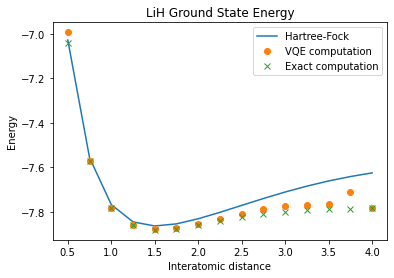

In [7]:
pylab.plot(distances,hf_energies,label='Hartree-Fock')
pylab.plot(distances,vqe_energies,'o',label='VQE computation')
pylab.plot(distances,exact_energies,'x',label='Exact computation')

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right')